# Two non-linear oscillators -- qubit representation

This notebook contains the code used to produce Figs. () and (). In particular:
1) Computation of the entanglement dynamics of the two oscillators

2) Relation between $\epsilon$ and $g$

3) Computation of the distinguishability between initially equivalent ensembles


The model underlying the whole notebook consists in two qubits $A,B$ with Hamiltonian functions
$$ h_{A,B}(\psi,\psi^*) = g \langle \psi| H_{\rm int} |\psi \rangle + \epsilon \frac{\langle\psi|\sigma_y^{A,B}|\psi\rangle^2}{\langle\psi|\psi\rangle} $$

In [5]:
from qutip import *
import numpy as np
import cmath,math
import matplotlib.pyplot as plt
import scipy.special, scipy.optimize

plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.preamble']= r'\usepackage[cm]{sfmath}'

#----------------------function-definitions-------------------------------------------
#-------------------------------------------------------------------------------------

def entropy_vn(rho, sparse=False):   # computes the Von Neumann entropy
    if rho.type == 'ket' or rho.type == 'bra':
        rho = ket2dm(rho)
    vals = rho.eigenenergies()
    nzvals = vals[vals > 1e-6]
    entrs = [scipy.special.xlogy(nzvals[k],nzvals[k]) for k in range(len(nzvals))]
    return float(np.real(-sum(entrs)))    

def progress(t):    
    k = t*100/tmax
    if k%2==0:
        print("Progress: ",str(int(k))+"%",end = "\r")
    return 0

pa0=np.array([[1,0,0,0],[0,1,0,0]])  # projects onto |0> for particle a
pa1=np.array([[0,0,1,0],[0,0,0,1]])  # projects onto |1> for particle a
pb0=np.array([[1,0,0,0],[0,0,1,0]])  # projects onto |0> for particle b
pb1=np.array([[0,1,0,0],[0,0,0,1]])  # projects onto |1> for particle b

def Hint(g):
    Hint= g* ( tensor(fock_dm(2,0),fock_dm(2,1))+tensor(fock_dm(2,1),fock_dm(2,0)) )
    return Hint

def Hnl(psi,epsilon,sigma):
    Y = expect(sigma,psi)/psi.norm()
    if epsilon==0: 
        val = Qobj(0)
    else:
        val =epsilon*(2*Y*sigma - Y*Y*qeye(2))
    return val

def trotter_dt(psi,g,epsilon,s1):  # computes the evolution for a time dt using a Trotterization method
    psia0 = (-1j*Hnl(Qobj(pa0*psi),epsilon,s1)*dt).expm()*(Qobj(pa0*psi))
    psia1 = (-1j*Hnl(Qobj(pa1*psi),epsilon,s1)*dt).expm()*(Qobj(pa1*psi))
    psi= tensor(basis(2,0),psia0)+tensor(basis(2,1),psia1) # free evolution of particle b
    psib0 = (-1j*Hnl(Qobj(pb0*psi),epsilon,s1)*dt).expm()*(Qobj(pb0*psi))
    psib1 = (-1j*Hnl(Qobj(pb1*psi),epsilon,s1)*dt).expm()*(Qobj(pb1*psi))
    psi= tensor(psib0,basis(2,0))+tensor(psib1,basis(2,1)) # free evolution of particle a
    psi=(-1j*Hint(g)*dt).expm()*psi  # evolution under interaction term
    return psi

def evolve(psi0,times,epsilon,g,s1,printflag=True): # returns the evolved state and its entanglement for all times
    if printflag: print("Computing entanglement dynamics for epsilon =",epsilon,"and g =",g,"...")
    psit=[psi0]
    entr=[0]  
    for t in times[1:]:
        psit.append(trotter_dt(psit[-1],g,epsilon,s1))
        entr.append(entropy_vn(psit[-1].ptrace(0))/math.log(2))
        if printflag: progress(t)
    if printflag: print("--> completed!")
    return [psit,entr]

def plot_entanglement_dynamics(psi0,times,epsvals,s1,save=True): # epsvals=[eps1,eps2,...]
    fig = plt.figure()
    for eps in epsvals:
        entr = evolve(psi0,times,eps,1,s1)[1]
        plt.plot(times,np.array(entr),lw=2.,label=r'$\epsilon =%g$'%(eps))
    plt.legend()
    plt.margins(0)
    plt.xlabel(r'$t$',size=15)
    plt.ylabel(r'$E(\psi)$',size=15)
    if save: plt.savefig('nl_osc_entglmnt_g=%g_dt=%g_tmax=%g.png'%(g,dt,tmax))
    plt.tight_layout()
    plt.show()
                         
def plot_entanglement_overlap(psi0,times,vals,s1,save=True): # vals=[[eps1,g1],[eps2,g2],...]
    fig = plt.figure()
    for x in vals:
        eps0,g0 = x[0],x[1]
        entr = evolve(psi0,times,eps0,g0,s1)[1]
        plt.plot(times,np.array(entr),lw=2.5,label=r'$g=%g,\epsilon=%g$'%(g0,eps0))
    plt.legend(prop={'size':16})
    plt.margins(0)
    plt.xlabel(r'$t$',size=20)
    plt.ylabel(r'$E_{(g,\epsilon)}(t)$',size=20)
    if save: plt.savefig('nl_osc_overlap_dt=%g_tmax=%g.svg'%(dt,tmax),dpi=600)
    plt.tight_layout()
    plt.show()


# 1. Entanglement Dynamics

Set values for the max simulation time $t_{max}$, the time step $dt$, and set values for the list vals which should be of the form $[[\epsilon_1,g_1],\dots,[\epsilon_N,g_N]]$ where $\epsilon_k$ and $g_k$ are the $k$-th values of nonlinear strength and interaction coupling to compare.

Computing entanglement dynamics for epsilon = 1 and g = 0.5 ...
--> completed!
Computing entanglement dynamics for epsilon = 0.5 and g = 0.5 ...
--> completed!
Computing entanglement dynamics for epsilon = 0 and g = 0.5 ...
--> completed!


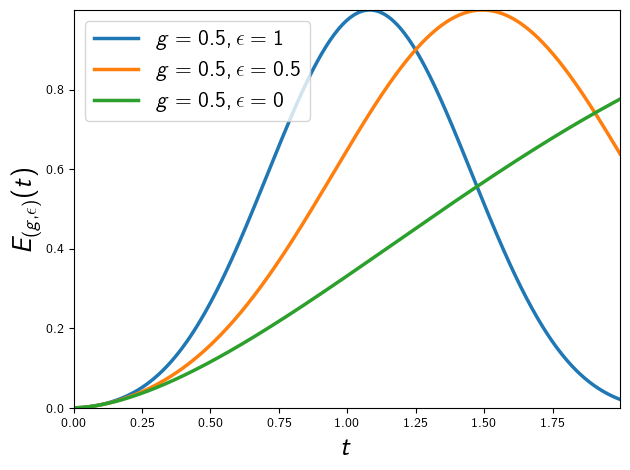

In [8]:

#-----------------------PARAMETERS----------------------------------------------------
#-------------------------------------------------------------------------------------

tmax = 2
dt = 0.005
vals = [[1,0.5],[0.5,0.5],[0,0.5]]



#-------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------

times=np.arange(0.,tmax,dt)

zero = ket("0")
one = ket("1")

sx = qutip.sigmax()
sy = qutip.sigmay()
sz = qutip.sigmaz()

psi0 = tensor(zero+one,zero+one)   # initial state
psi0 = psi0/psi0.norm()

plot_entanglement_overlap(psi0,times,vals,sy,False)


### 1.1 Fit for the entanglement oscillations

This section fits the entanglement dynamics using the scipy.optimize function curve_fit()

1.09 5.764
Computing entanglement dynamics for epsilon = 0.3 and g = 1 ...
--> completed!
[1.30453851] [[1.43085217e-06]]


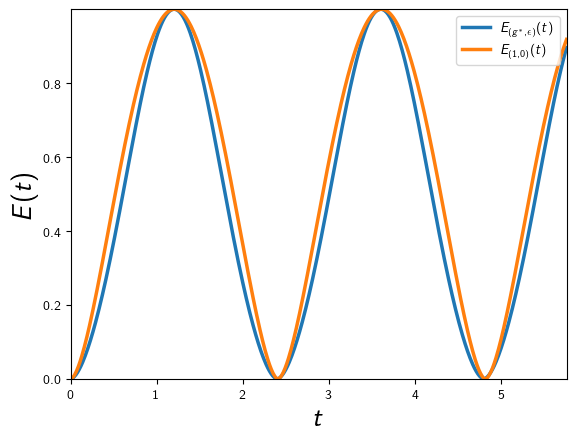

In [9]:
def vn_entropy(q):
    return  - scipy.special.xlogy(q,q) - scipy.special.xlogy(1-q,1-q) 

def f_model(x, w):
    s = (np.sin(0.5*w*x))**2
    return vn_entropy(s)/math.log(2)

#-------------------------------------------------------------------------------------
#---------------------parameters------------------------------------------------------

g = 1
eps = 0.3

wapprox =  g+eps**2 if eps<=(0.5*math.pi)**(2/3) else g+(0.5*math.pi)*math.sqrt(eps)
tmax = 2*math.pi / wapprox
print(round(wapprox,3),round(tmax,3))
dt = 0.01
times = np.arange(0.,tmax,dt)

psi0 = tensor(zero+one,zero+one)   # initial state
psi0 = psi0/psi0.norm()

#-------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------

entr = np.array(evolve(psi0,times,eps,g,sy)[1])  # compute entanglement dynamics for psi0 as initial state

funct = f_model  # function used for fit

popt, pcov = scipy.optimize.curve_fit(f=funct,xdata=times,ydata=entr,bounds=(0,10),p0=wapprox,method='trf') # fit

print(popt,pcov)

fittedvals = np.array([funct(t,popt[0]) for t in times])

fit=plt.figure()
plt.plot(times,entr,lw=2.5,label=r'$E_{(g^*,\epsilon)}(t)$')
plt.plot(times,fittedvals,lw=2.5,label=r'$E_{(1,0)}(t)$')
plt.margins(0)
plt.xlabel(r'$t$',size=20)
plt.ylabel(r'$E(t)$',size=20)
plt.legend()
plt.savefig('nl_osc_overlap-_eps=%g.svg'%(eps),dpi=600)
plt.show()




### 1.2 Mean square deviation from the linear functional form

The relation found above tells us for what values $(g^*(\epsilon),\epsilon)$ the entanglement dynamics $E_{(g^*(\epsilon),\epsilon)}$ approximately reproduces $E_{(1,0)}$. Here we compute the distance between these two curves as
$$ d(\epsilon)=\frac{1}{T}\int_0^T |E_{(1,0)}(t)-E_{(g^*(\epsilon),\epsilon)}(t)|^2 dt $$

Computing entanglement dynamics for epsilon = 0 and g = 1 ...
--> completed!
[0.0, 1.0, 0.0]
[0.5102, 1.573, 0.0111]
[1.0204, 2.1515, 0.0206]
[1.5306, 2.5584, 0.0274]
[2.0408, 2.9708, 0.032]
[2.551, 3.3249, 0.0342]
[3.0612, 3.6385, 0.0352]
[3.5714, 3.9242, 0.0358]
[4.0816, 4.1898, 0.0362]
[4.5918, 4.4393, 0.0364]
[5.102, 4.6744, 0.0367]
[5.6122, 4.8968, 0.0369]
[6.1224, 5.1077, 0.0371]
[6.6327, 5.3085, 0.0373]
[7.1429, 5.5012, 0.0376]
[7.6531, 5.6856, 0.0379]
[8.1633, 5.8641, 0.0382]
[8.6735, 6.0361, 0.0385]
[9.1837, 6.2027, 0.0389]
[9.6939, 6.3642, 0.0392]
[10.2041, 6.5206, 0.0396]
[10.7143, 6.6737, 0.0399]
[11.2245, 6.8235, 0.0402]
[11.7347, 6.9703, 0.0405]
[12.2449, 7.1121, 0.0409]
[12.7551, 7.2527, 0.0411]
[13.2653, 7.3904, 0.0414]
[13.7755, 7.5251, 0.0416]
[14.2857, 7.6567, 0.0419]
[14.7959, 7.7852, 0.0422]
[15.3061, 7.9129, 0.0424]
[15.8163, 8.0375, 0.0427]
[16.3265, 8.1614, 0.0429]
[16.8367, 8.2848, 0.043]
[17.3469, 8.4024, 0.0433]
[17.8571, 8.522, 0.0433]
[18.3673, 8.6384, 0.04

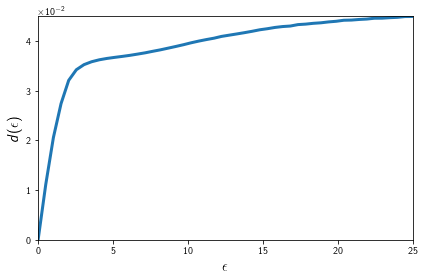

In [45]:
def msd(f1,f2,times):
    f = np.array([abs(f1[t]-f2[t])**2 for t in range(len(f1))])
    val = scipy.integrate.simps(f,times)
    return val

#-------------------------------------------------------------------------------------
#---------------------parameters------------------------------------------------------

epsmin = 0
epsmax = 25
epsrange = np.linspace(epsmin,epsmax,50)
omegaopts = []
sy = qutip.sigmay()

tmax = math.pi
dt =0.001
times = np.arange(0.,tmax,dt)

g = 1

psi0 = tensor(zero+one,zero+one)   # initial state
psi0 = psi0/psi0.norm()

#-------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------

entr0 = evolve(psi0,times,0,g,sy)[1]
dim = len(entr0)


fig_ent = plt.figure()
ax_ent = plt.axes()

file = open('omega_of_eps_-_eps=%g_%g_tmax=%g.txt'%(epsmin,epsmax,tmax), "w")

deps = []

for eps in epsrange:
    wapprox = g+eps**2 if eps<=(0.5*math.pi)**(2/3) else g+(0.5*math.pi)*math.sqrt(eps)
    tmax = 2*math.pi / wapprox
    times = np.arange(0.,tmax,dt)
    entr = evolve(psi0,times,eps,g,sy,False)[1]
    val,cov = scipy.optimize.curve_fit(f=f_model, xdata=times, ydata=entr, p0=wapprox, method='lm')
    x = val[0] 
    omegaopts.append(x)
    file.write(str(x)+" "+str(eps)+"\n")
    
    f1 = np.array([f_model(t,x) for t in times])
    f2 = entr
    val = msd(f1,f2,times)/tmax
    deps.append(val)
    print([round(eps,4),round(x,4),round(val,4)])

plt.plot(epsrange,np.array(deps),lw=3)   
plt.xlabel(r'$\epsilon$',size=15)
plt.ylabel(r'$d(\epsilon)$',size=15)
plt.yticks(np.array([0.,0.01,0.02,0.03,0.04]))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.margins(0)
plt.savefig('nl_osc_d_of_eps-_eps=%g_%g_tmax=%g.svg'%(epsmin,epsmax,tmax),dpi=600)
plt.tight_layout()
plt.show()

file.close()

# 2. Relation between $\epsilon$ and $g$

Here we compute the relation between $\epsilon$ and $g$. Set the minimum and maximum values for $\epsilon$, the simulation time $t_{max}$, the time step $dt$ and the reference value for $g$ (default is $g=1$).

Computing entanglement dynamics for epsilon = 0.0 and g = 1 ...
--> completed!
[0.0, 1.0, 0.0]
[0.07538, 1.0, 0.5239]
[0.07538, 0.9899, 0.2507]
[0.07538, 0.9798, 0.0802]
[0.07538, 0.9697, 0.0144]
[0.15075, 0.9697, 3.4534]
[0.15075, 0.9599, 2.7335]
[0.15075, 0.95011, 2.1024]
[0.15075, 0.94031, 1.5604]
[0.15075, 0.93052, 1.1074]
[0.15075, 0.92072, 0.7437]
[0.15075, 0.91093, 0.4697]
[0.15075, 0.90113, 0.2857]
[0.15075, 0.89134, 0.1926]
[0.15075, 0.88154, 0.1911]
[0.22613, 0.88154, 5.4697]
[0.22613, 0.87264, 4.6535]
[0.22613, 0.86373, 3.9122]
[0.22613, 0.85483, 3.2466]
[0.22613, 0.84592, 2.6569]
[0.22613, 0.83702, 2.1436]
[0.22613, 0.82812, 1.7068]
[0.22613, 0.81921, 1.3463]
[0.22613, 0.81031, 1.0621]
[0.22613, 0.8014, 0.854]
[0.22613, 0.7925, 0.722]
[0.22613, 0.78359, 0.6661]
[0.30151, 0.78359, 7.3965]
[0.30151, 0.77568, 6.5344]
[0.30151, 0.76776, 5.7356]
[0.30151, 0.75985, 5.0017]
[0.30151, 0.75193, 4.3341]
[0.30151, 0.74402, 3.7339]
[0.30151, 0.7361, 3.2018]
[0.30151, 0.72819, 2.7384]
[

[3.84422, 0.06958, 6.7222]
[3.84422, 0.06888, 6.6381]
[3.84422, 0.06817, 6.5988]
[3.9196, 0.06817, 6.7147]
[3.9196, 0.06749, 6.6353]
[3.9196, 0.0668, 6.6006]
[3.99497, 0.0668, 6.704]
[3.99497, 0.06612, 6.631]
[3.99497, 0.06545, 6.6024]
[4.07035, 0.06545, 6.691]
[4.07035, 0.06479, 6.6259]
[4.07035, 0.06413, 6.6049]
[4.14573, 0.06413, 6.6766]
[4.14573, 0.06348, 6.6208]
[4.14573, 0.06283, 6.6088]
[4.22111, 0.06283, 6.6617]
[4.22111, 0.0622, 6.6166]
[4.22111, 0.06156, 6.615]
[4.29648, 0.06156, 6.6477]
[4.29648, 0.06094, 6.6145]
[4.37186, 0.06094, 6.7006]
[4.37186, 0.06032, 6.6359]
[4.37186, 0.05971, 6.6153]
[4.44724, 0.05971, 6.6765]
[4.44724, 0.0591, 6.6266]
[4.44724, 0.0585, 6.6204]
[4.52261, 0.0585, 6.6556]
[4.52261, 0.05791, 6.6216]
[4.59799, 0.05791, 6.7016]
[4.59799, 0.05733, 6.6398]
[4.59799, 0.05674, 6.622]
[4.67337, 0.05674, 6.6726]
[4.67337, 0.05617, 6.6292]
[4.74874, 0.05617, 6.7196]
[4.74874, 0.0556, 6.6505]
[4.74874, 0.05503, 6.6258]
[4.82412, 0.05503, 6.6838]
[4.82412, 0.0544

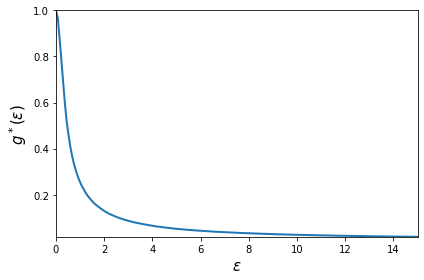

In [18]:
epsmin = 0.
epsmax = 15.
g = 1
tmax = 5
dt = 0.03
#===========================================================

epsrange = np.linspace(epsmin,epsmax,200)
gopts = []
sy = qutip.sigmay()

times = np.arange(0.,tmax,dt)

entr0 = evolve(psi0,times,epsmin,g,sy)[1]
dim = len(entr0)

file = open('eps_of_g_-_eps=%g_%g_tmax=%g.txt'%(epsmin,epsmax,tmax), "w")
fig2 = plt.figure()

gstar = 1
for eps in epsrange:
    vals = []
    val0 = 10000
    for g in np.linspace(0.,gstar,100)[::-1]:
        entr = evolve(psi0,times,eps,g,sy,False)[1]
        val = sum([(entr[k]-entr0[k])**2 for k in range(dim)])
        vals.append([g,val])
        if val<val0: val0 = val
        if val>val0: break
        print([round(eps,5),round(g,5),round(val,4)])
    gstar = min(vals, key=lambda x: x[1])[0]  #find the pair [g,val] that has the min val, and take its corresp. g
    gopts.append(gstar) 
    file.write(str(gstar)+" "+str(eps)+"\n")
    

plt.plot(epsrange,np.array(gopts),lw=2.)   
#plt.axhline(y=0., linestyle='--')
plt.xlabel(r'$\epsilon$',size=15)
plt.ylabel(r'$g^*(\epsilon)$',size=15)
plt.margins(0)
plt.savefig('nl_osc_g_of_eps-_eps=%g_%g_tmax=%g.png'%(epsmin,epsmax,tmax),dpi=600)
plt.tight_layout()
plt.show()

file.close()